# Can we predict death?
## Predicting Cancer Survival Time

* Jon Kartago Lamida - 1004796
* Mohamad Ridzuan Yusop - 1004772
* Muhammad Muhaimin Bin Omar - 1004914

## Motivation

WHO published some cancer key facts in 2018. From the facts, we can see the importance of eradicating cancer by improving detection, prediction and treatment. In this project, we want to apply our machine learning knowledge in selecting features and to predict non-small cell lung cancer (NSCLC) patients' survival time using some linear regression models. We will analyze the accuracy of different features and models.

## Notebook Configuration

Update the following configuration to adjust the notebook execution

In [124]:
DATA_VERSION = "v1" # or "v1|v2" v1: Ridzuan Original Data clean up. v2: Jon clean up implementation with removed na.
TEST_SIZE = 0.2
RANDOM_STATE = 42

DATA_URL = "https://wiki.cancerimagingarchive.net/download/attachments/16056854/NSCLC%20Radiomics%20Lung1.clinical-version3-Oct%202019.csv?version=1&modificationDate=1572013183040&api=v2"
DOWNLOAD_PATH = "data.csv"

COLUMN_NAMES = ["PatientID", "Age", "Clinical.T.Stage", "Clinical.N.Stage", "Clinical.M.Stage", "Overall.Stage", 
                "Histology", "Gender", "Survival.Time", "DeadStatus.Event"]

## Import and Download The Data

In [125]:
import pandas as pd
import numpy as np
import os
import tarfile
import urllib.request

def fetch_data(data_url = DATA_URL, download_path = DOWNLOAD_PATH):
    urllib.request.urlretrieve(data_url, download_path)

def load_data(download_path = DOWNLOAD_PATH):
    return pd.read_csv(download_path)

fetch_data()
raw_data = load_data()

raw_data.columns = COLUMN_NAMES

## Understand The Data

In [126]:
print(raw_data.head())
print(raw_data.info())

   PatientID      Age  Clinical.T.Stage  Clinical.N.Stage  Clinical.M.Stage  \
0  LUNG1-001  78.7515               2.0                 3                 0   
1  LUNG1-002  83.8001               2.0                 0                 0   
2  LUNG1-003  68.1807               2.0                 3                 0   
3  LUNG1-004  70.8802               2.0                 1                 0   
4  LUNG1-005  80.4819               4.0                 2                 0   

  Overall.Stage                Histology Gender  Survival.Time  \
0          IIIb               large cell   male           2165   
1             I  squamous cell carcinoma   male            155   
2          IIIb               large cell   male            256   
3            II  squamous cell carcinoma   male            141   
4          IIIb  squamous cell carcinoma   male            353   

   DeadStatus.Event  
0                 1  
1                 1  
2                 1  
3                 1  
4                 

In [127]:
# Check Is there any  Non Avialable Data 
display(raw_data.isna().any())

PatientID           False
Age                  True
Clinical.T.Stage     True
Clinical.N.Stage    False
Clinical.M.Stage    False
Overall.Stage        True
Histology            True
Gender              False
Survival.Time       False
DeadStatus.Event    False
dtype: bool

In [128]:
# Removing Non Availabile Datas from the raw
raw_data = raw_data.fillna(-1)

In [129]:
# Check Is there any Non Available Data 
display(raw_data.isna().any())

PatientID           False
Age                 False
Clinical.T.Stage    False
Clinical.N.Stage    False
Clinical.M.Stage    False
Overall.Stage       False
Histology           False
Gender              False
Survival.Time       False
DeadStatus.Event    False
dtype: bool

<AxesSubplot:xlabel='DeadStatus.Event', ylabel='count'>

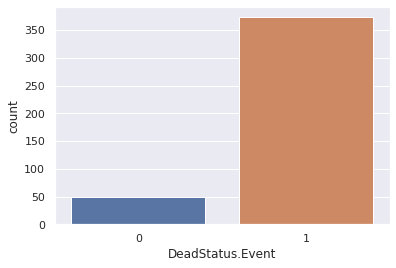

In [130]:
# Now lets check the class distributions
import seaborn as sns
raw_data["DeadStatus.Event"].value_counts()
sns.countplot(x="DeadStatus.Event",data=raw_data)

In [131]:
raw_data['Survival.Time'].value_counts()

303     4
515     3
220     3
98      3
249     3
       ..
336     1
337     1
1362    1
1738    1
512     1
Name: Survival.Time, Length: 377, dtype: int64

<AxesSubplot:xlabel='Histology', ylabel='count'>

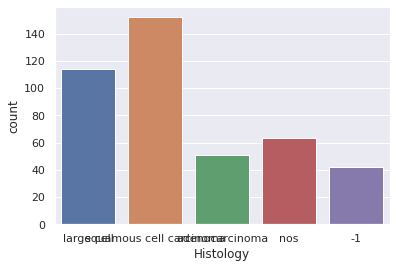

In [132]:
raw_data['Histology'].value_counts()
sns.countplot(x="Histology",data=raw_data)

<AxesSubplot:xlabel='Gender', ylabel='count'>

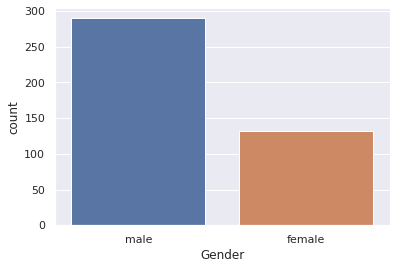

In [133]:
raw_data['Gender'].value_counts()
sns.countplot(x="Gender",data=raw_data)

In [134]:
pd.crosstab(index=raw_data['Gender'], columns=raw_data['DeadStatus.Event'])

DeadStatus.Event,0,1
Gender,,
female,22,110
male,27,263


In [135]:
pd.crosstab(index=raw_data['Gender'], columns=raw_data['Clinical.T.Stage'])

Clinical.T.Stage,-1.0,1.0,2.0,3.0,4.0,5.0
Gender,,,,,,
female,1,35,45,15,35,1
male,0,58,111,38,82,1


In [136]:
pd.crosstab(index=raw_data['Gender'], columns=raw_data['DeadStatus.Event'])

DeadStatus.Event,0,1
Gender,,
female,22,110
male,27,263


<AxesSubplot:xlabel='Age'>

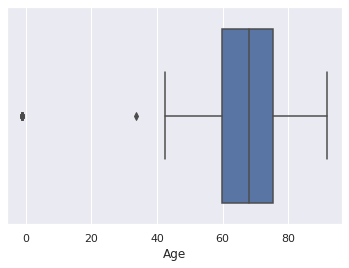

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt  
sns.boxplot(x=raw_data.Age)

<AxesSubplot:xlabel='Clinical.T.Stage', ylabel='count'>

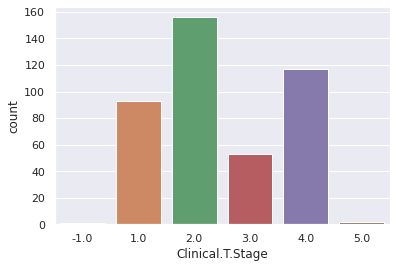

In [138]:
raw_data["Clinical.T.Stage"].value_counts()
sns.countplot(x="Clinical.T.Stage",data=raw_data)

<AxesSubplot:xlabel='Clinical.M.Stage', ylabel='count'>

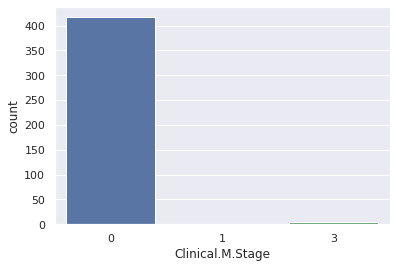

In [139]:
raw_data["Clinical.M.Stage"].value_counts()
sns.countplot(x="Clinical.M.Stage",data=raw_data)
# There are too many 0 stage in this attribute. We might need to drop this feature.

<AxesSubplot:xlabel='Clinical.N.Stage', ylabel='count'>

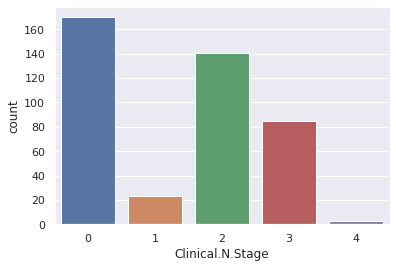

In [140]:
raw_data["Clinical.N.Stage"].value_counts()
sns.countplot(x="Clinical.N.Stage",data=raw_data)

In [141]:
#Find the correlation of each coffecients
raw_data.corr()

,Age,Clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Survival.Time,DeadStatus.Event
Age,1.000000,0.026531,-0.096175,-0.024185,-0.040476,0.056673
Clinical.T.Stage,0.026531,1.000000,0.034110,0.055951,0.017221,-0.052694
Clinical.N.Stage,-0.096175,0.034110,1.000000,0.095097,-0.046084,-0.040022
Clinical.M.Stage,-0.024185,0.055951,0.095097,1.000000,-0.003276,0.037913
Survival.Time,-0.040476,0.017221,-0.046084,-0.003276,1.000000,-0.655487
DeadStatus.Event,0.056673,-0.052694,-0.040022,0.037913,-0.655487,1.000000


array([[<AxesSubplot:xlabel='Age', ylabel='Age'>,
        <AxesSubplot:xlabel='Clinical.T.Stage', ylabel='Age'>,
        <AxesSubplot:xlabel='Clinical.N.Stage', ylabel='Age'>,
        <AxesSubplot:xlabel='Clinical.M.Stage', ylabel='Age'>,
        <AxesSubplot:xlabel='Survival.Time', ylabel='Age'>,
        <AxesSubplot:xlabel='DeadStatus.Event', ylabel='Age'>],
       [<AxesSubplot:xlabel='Age', ylabel='Clinical.T.Stage'>,
        <AxesSubplot:xlabel='Clinical.T.Stage', ylabel='Clinical.T.Stage'>,
        <AxesSubplot:xlabel='Clinical.N.Stage', ylabel='Clinical.T.Stage'>,
        <AxesSubplot:xlabel='Clinical.M.Stage', ylabel='Clinical.T.Stage'>,
        <AxesSubplot:xlabel='Survival.Time', ylabel='Clinical.T.Stage'>,
        <AxesSubplot:xlabel='DeadStatus.Event', ylabel='Clinical.T.Stage'>],
       [<AxesSubplot:xlabel='Age', ylabel='Clinical.N.Stage'>,
        <AxesSubplot:xlabel='Clinical.T.Stage', ylabel='Clinical.N.Stage'>,
        <AxesSubplot:xlabel='Clinical.N.Stage', ylabel='C

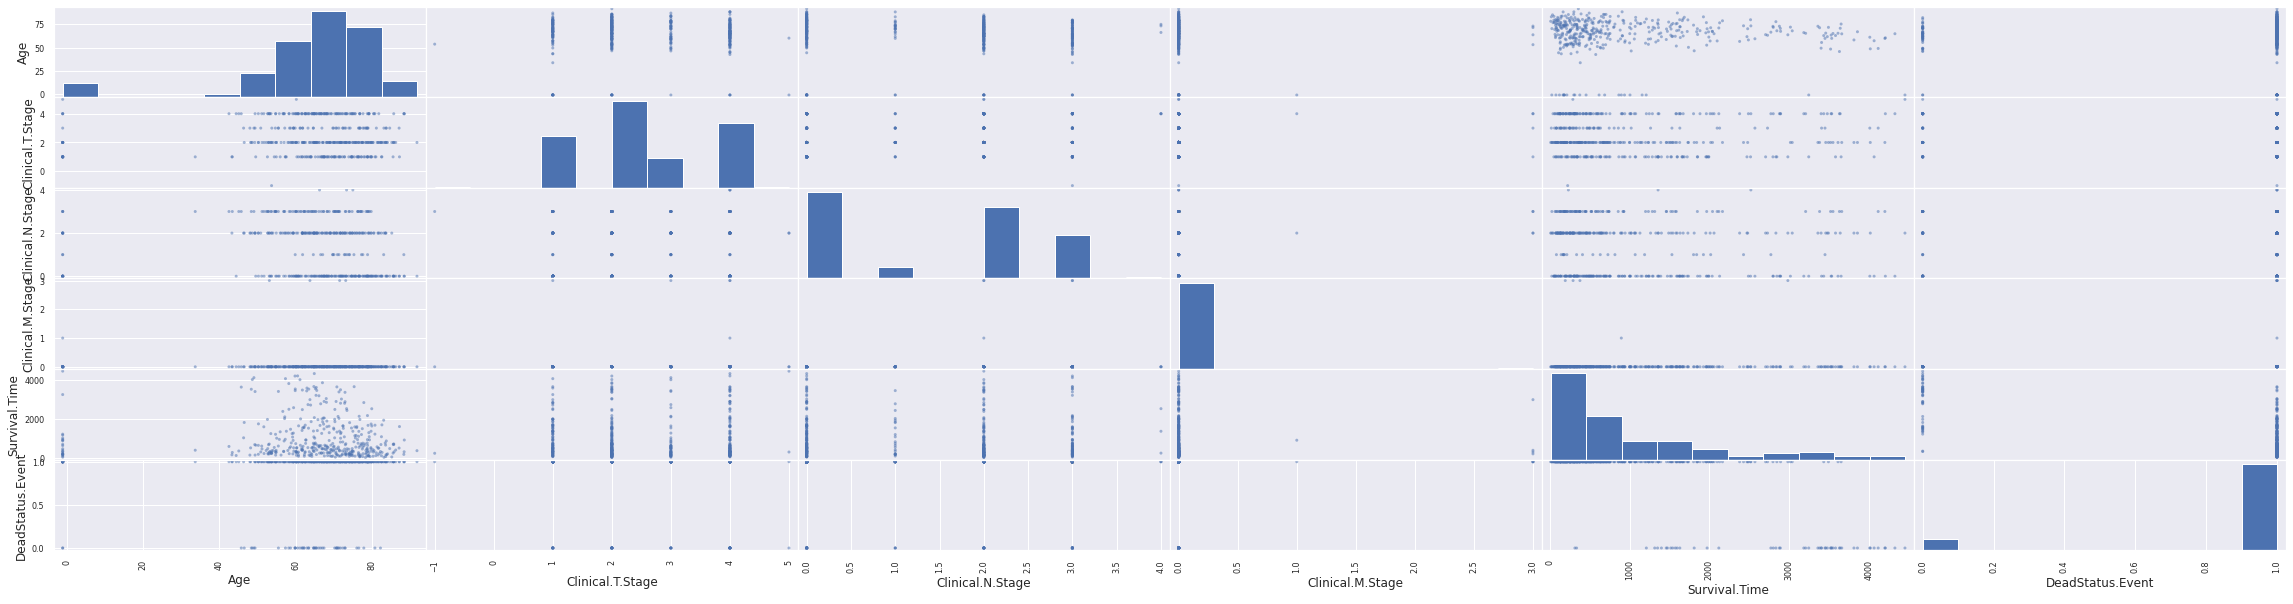

In [142]:
# Correlation using pandas
from pandas.plotting import scatter_matrix

scatter_matrix(raw_data, figsize=(40, 10))

## Scatterplot of The Dataset

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Age', ylabel='Survival.Time'>

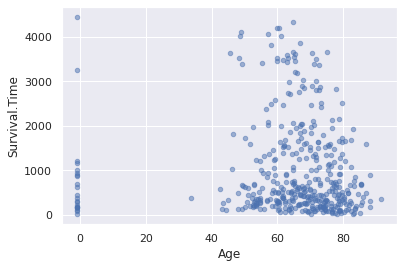

In [143]:
# Plot
raw_data.plot.scatter(x='Age', y='Survival.Time', alpha=0.5)
# Need to remove age 0

# Data Cleanup
## Data V1

In [144]:
# make dictionary for string values
string_val_keys = ['Overall.Stage', 'Histology', 'Gender']
dictionary = {}
for key in string_val_keys:
    classes = list(raw_data[key].unique())
    if -1 in classes:
        classes.remove(-1)
    dictionary[key] = classes

# Seperate independent variable named as data and dependent variable name lablels
data = []
survival_times = []
# deadstatus.event
dead_status_events = []
for i in range(len(raw_data.values)):
    if raw_data['DeadStatus.Event'][i] == -1:
        continue
    data_line = []
    for key in raw_data.keys()[1:]:
        if raw_data[key][i] == -1:
            data_line.append(-1)
            continue
        if key in string_val_keys:
            data_line.append(dictionary[key].index(raw_data[key][i]))
        else:
            data_line.append(raw_data[key][i])
    data.append(data_line[:-2])
    # Target is the last two columns
    survival_times.append(data_line[-2:-1][0]) # Survival.time
    dead_status_events.append(data_line[-1]) # deadstatus.event
print('There are %d items in the given dataset' % len(data))

There are 422 items in the given dataset


## Data V2

In [145]:
stage_mapping = {
    "I": 1,
    "II": 2,
    "IIIa": 3,
    "IIIb": 4
}
gender_mapping = {
    "male": 0,
    "female": 1
}
histology_mapping = {
    'large cell': 0,
    'squamous cell carcinoma': 1,
    'adenocarcinoma': 2,
    'nos': 3
}

data_v2 = raw_data.copy()
data_v2["Overall.Stage"] = raw_data[["Overall.Stage"]].applymap(lambda x: stage_mapping.get(x))
data_v2["Gender"] = raw_data[["Gender"]].applymap(lambda x: gender_mapping.get(x))
data_v2["Histology"] = raw_data[["Histology"]].applymap(lambda x: histology_mapping.get(x))

data_v2 = data_v2.dropna()
survival_times_v2 = data_v2[['Survival.Time']].values.ravel()
dead_status_events_v2 = data_v2[['DeadStatus.Event']].values.ravel()
# Remove PatientID and labels
data_v2 = data_v2.iloc[:, 1:-2].values
data_v2
print('There are %d items in the given dataset' % len(data_v2))

There are 379 items in the given dataset


## Train Test Split

In [146]:
#Split the data nd labels set into 80% as training and 20% as testing
from sklearn.model_selection import train_test_split

def run_train_test_split(data_version = DATA_VERSION, test_size = TEST_SIZE, random_state = RANDOM_STATE):
    if (DATA_VERSION == "v1"):
        X_train, X_test, y_train_survival_times, y_test_survival_times = train_test_split(data, survival_times, test_size=test_size, random_state=random_state)
        X_train, X_test, y_train_dead_status_events, y_test_dead_status_events = train_test_split(data, dead_status_events, test_size=test_size, random_state=random_state)
    else:
        X_train, X_test, y_train_survival_times, y_test_survival_times = train_test_split(data_v2, survival_times_v2, test_size=test_size, random_state=random_state)
        X_train, X_test, y_train_dead_status_events, y_test_dead_status_events = train_test_split(data_v2, dead_status_events_v2, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train_survival_times, y_train_dead_status_events, y_test_survival_times, y_test_dead_status_events

X_train, X_test, y_train_survival_times, y_train_dead_status_events, y_test_survival_times, y_test_dead_status_events = run_train_test_split()
print(f'There are {len(X_train)} items in the train dataset')
print(f'There are {len(X_test)} items in the test dataset')

There are 337 items in the train dataset
There are 85 items in the test dataset


In [147]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sd = sc.fit_transform(X_train)
X_test_sd = sc.transform(X_test)

# Predicting DeadStatus.Event Classification

In [148]:
classifications = []

## Logistic Regression Model

In [149]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report


clf = LogisticRegression(random_state = 0)

clf.fit(X_train_sd, y_train_dead_status_events)
y_pred = clf.predict(X_test_sd)

cm = confusion_matrix(y_test_dead_status_events, y_pred)
report = classification_report(y_test_dead_status_events, y_pred)
acc = accuracy_score(y_test_dead_status_events, y_pred)*100

classifications.append({
    "name": clf.__class__.__name__,
    "cm": cm,
    "acc": acc,
    "report": report
})

/home/lamida/mssd/handson-ml/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(66.5, 0.5, 'Truth')

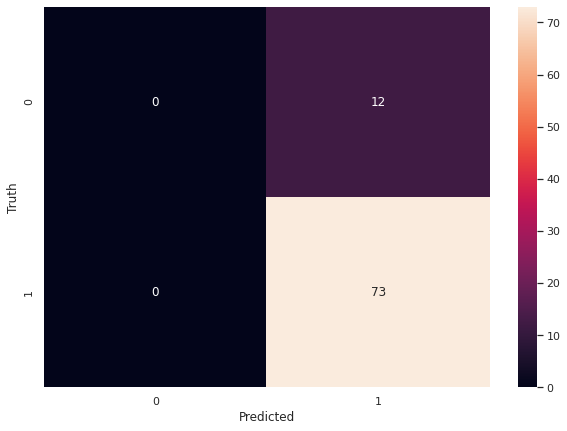

In [150]:
import matplotlib.pyplot as plt  
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

## K-NN Algorithom

Steps
1.Create new data set without categorical variable and assigned name as data
2.Create new data set Only with categorical variable and assigned name as lables
3.Split the data set into 80% as Training and assigned name as x_train as well as 20% as Testing & Assigned name as x_test
4.Split the labels set into 80% as Training and assigned name as y_train as well as 20 as Testing & Assigned name as y_test


In [151]:
#Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler ()
x_train_normal = scaler.fit_transform(X_train)
x_test_normal = scaler.fit_transform(X_test)

In [152]:
from sklearn import neighbors

n_neighbors = 10
weights = 'uniform'

clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf.fit(x_train_normal, y_train_dead_status_events)
y_pred = clf.predict(x_test_normal)
cm = confusion_matrix(y_test_dead_status_events, y_pred)
report = classification_report(y_test_dead_status_events, y_pred)
acc = accuracy_score(y_test_dead_status_events, y_pred)*100

classifications.append({
    "name": clf.__class__.__name__,
    "cm": cm,
    "acc": acc,
    "report": report
})

Text(66.5, 0.5, 'Truth')

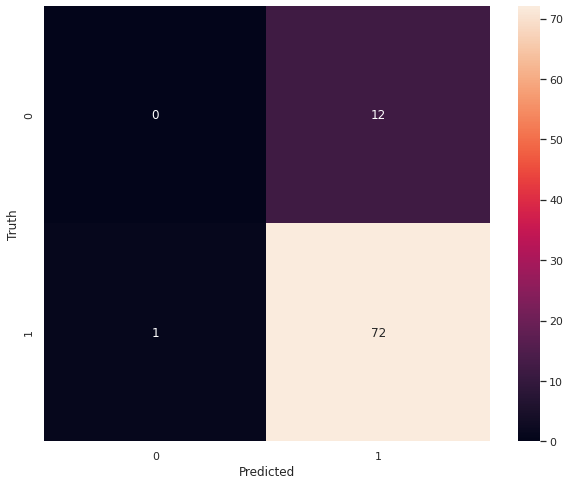

In [153]:
import matplotlib.pyplot as plt  
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

## Decision Tree

In [154]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf = clf.fit(X_train_sd,y_train_dead_status_events)
clf.fit(X_train_sd, y_train_dead_status_events)
y_pred = clf.predict(X_test_sd)
cm = confusion_matrix(y_test_dead_status_events, y_pred)
report = classification_report(y_test_dead_status_events, y_pred)
acc = accuracy_score(y_test_dead_status_events, y_pred)*100

classifications.append({
    "name": clf.__class__.__name__,
    "cm": cm,
    "acc": acc,
    "report": report
})


Text(66.5, 0.5, 'Truth')

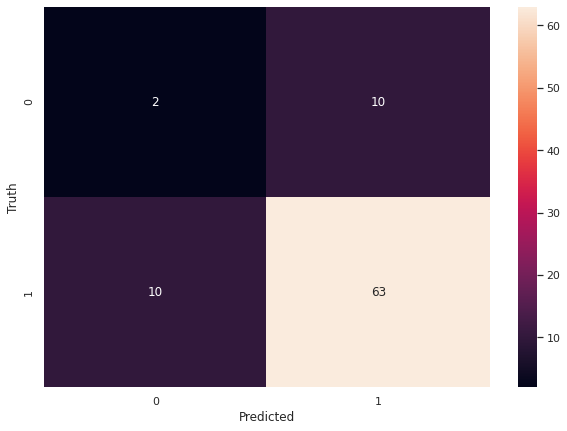

In [155]:
import matplotlib.pyplot as plt  
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

## Naive Bayes Model


In [156]:
# Training the Naive Bayes model on the Training set
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train_sd, y_train_dead_status_events)
y_pred = clf.predict(X_test_sd)
cm = confusion_matrix(y_test_dead_status_events, y_pred)
report = classification_report(y_test_dead_status_events, y_pred)
acc = accuracy_score(y_test_dead_status_events, y_pred)*100

classifications.append({
    "name": clf.__class__.__name__,
    "cm": cm,
    "acc": acc,
    "report": report
})




Text(66.5, 0.5, 'Truth')

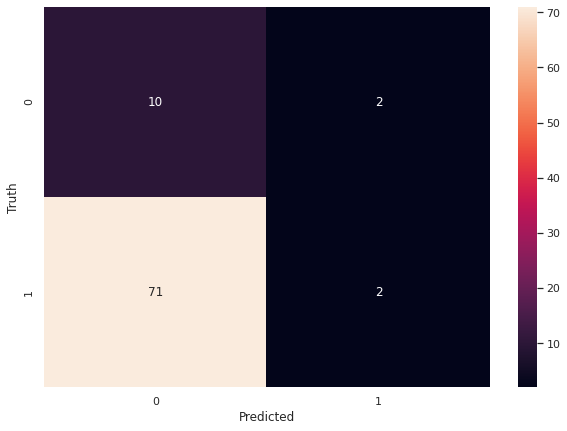

In [157]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

## RandomForest Model

In [158]:
# Training the Random Forest Classification model on the Training set
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
clf.fit(X_train_sd, y_train_dead_status_events)
y_pred = clf.predict(X_test_sd)
cm = confusion_matrix(y_test_dead_status_events, y_pred)
report = classification_report(y_test_dead_status_events, y_pred)
acc = accuracy_score(y_test_dead_status_events, y_pred)*100

classifications.append({
    "name": clf.__class__.__name__,
    "cm": cm,
    "acc": acc,
    "report": report
})


Text(66.5, 0.5, 'Truth')

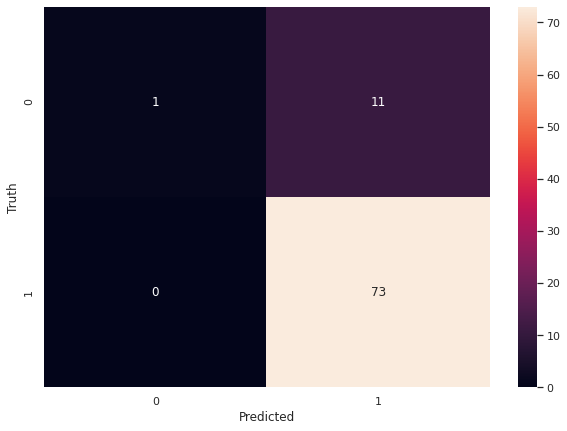

In [159]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

## Support Vector Machine (SVM)

In [160]:
# Training the SVM model on the Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
clf.fit(X_train_sd, y_train_dead_status_events)
y_pred = clf.predict(X_test_sd)
cm = confusion_matrix(y_test_dead_status_events, y_pred)
report = classification_report(y_test_dead_status_events, y_pred)
acc = accuracy_score(y_test_dead_status_events, y_pred)*100

classifications.append({
    "name": clf.__class__.__name__,
    "cm": cm,
    "acc": acc,
    "report": report
})


Text(66.5, 0.5, 'Truth')

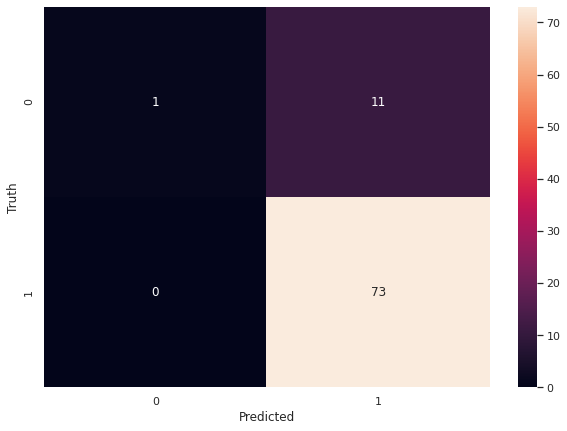

In [161]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Compare All Models

In [162]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

In [163]:
#Comparing classifiers via voting
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()
voting_clf = VotingClassifier(
estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
voting='hard'
)
voting_clf.fit(X_train_sd, y_train_dead_status_events)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [164]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train_sd, y_train_dead_status_events)
    y_pred = clf.predict(X_test_sd)
    print(clf.__class__.__name__, accuracy_score(y_test_dead_status_events, y_pred))

LogisticRegression 0.8588235294117647
RandomForestClassifier 0.8588235294117647
SVC 0.8588235294117647
VotingClassifier 0.8588235294117647


# Predicting DeadStatus.Event Classification Summary


In [165]:
from textwrap import dedent

for record in classifications:
    print(dedent(f"""
    Model: {record["name"]}
    Confusion Matrix: 
    {str(record["cm"]).strip()}
    Accuracy: {record["acc"]}
    Report: 
    {record["report"]}
    """))
    


    Model: LogisticRegression
    Confusion Matrix: 
    [[ 0 12]
 [ 0 73]]
    Accuracy: 85.88235294117646
    Report: 
                  precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.86      1.00      0.92        73

    accuracy                           0.86        85
   macro avg       0.43      0.50      0.46        85
weighted avg       0.74      0.86      0.79        85



    Model: KNeighborsClassifier
    Confusion Matrix: 
    [[ 0 12]
 [ 1 72]]
    Accuracy: 84.70588235294117
    Report: 
                  precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.86      0.99      0.92        73

    accuracy                           0.85        85
   macro avg       0.43      0.49      0.46        85
weighted avg       0.74      0.85      0.79        85



    Model: DecisionTreeClassifier
    Confusion Matrix: 
    [[ 2 10]
 [10 63]]
    Accur


I have used Logistic Regression, KNN, Decission Tree, Random Forest and SVM for analysis the data 

## Accuracy of Each model
* Accuracy of Logistic Regression =89.41176470588236
* Accuracy of knn=87.05882352941177
* Accuracy of Decision Tree=89.41176470588236
* Accuracy of Naive Bayes =85.88235294117646
* Accuracy of Random Forest=85.88235294117646
* Accuracy Of SVM=85.88235294117646

Here, Logistic Regression model Accuracy higher than other Machine learning model, so we could suggest Logistic Regression Model best for this Prediction 

## Advantage of Logistic Regression Model for This Analysis
* It has good Accuracy among them Moreover#
* It has Good sensitivity to predict which pation has deadstatus.event ==1 So, It's good model for that

# Predicting Survival.Time

In [166]:
from sklearn.metrics import max_error, mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score

def regression_metrics(X_train, y_test_survival_times, y_pred):
    #print(f"Coefficients: {model.coef_}")
    return dedent(f"""
    Max error: {max_error(y_test_survival_times, y_pred)} 
    Mean Squared Error: {mean_squared_error(y_test_survival_times, y_pred)}
    Mean Absolute Error: {mean_absolute_error(y_test_survival_times, y_pred)}
    Median Absolute Error: {median_absolute_error(y_test_survival_times, y_pred)}
    Explained Variance Score: {explained_variance_score(y_test_survival_times, y_pred)}
    Coeffecient of Determination (rw): {r2_score(y_test_survival_times, y_pred)}""")
    #for i in range(len(y_test_survival_times)):
    #    print(f"features: {X_test[i]} actual: {y_test_survival_times[i]} predicted: {y_pred[i]}")

In [167]:
regressions = []

## LinearRegression

In [168]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train_survival_times)
y_pred = model.predict(X_test)


regressions.append({
    "name": model.__class__.__name__,
    "metrics": regression_metrics(X_train, y_test_survival_times, y_pred)
})

## RidgeRegression

In [169]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=.5)
model.fit(X_train, y_train_survival_times)
y_pred = model.predict(X_test)

regressions.append({
    "name": model.__class__.__name__,
    "metrics": regression_metrics(X_train, y_test_survival_times, y_pred)
})

## Lasso

In [170]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=.5)
model.fit(X_train, y_train_survival_times)
y_pred = model.predict(X_test)

regressions.append({
    "name": model.__class__.__name__,
    "metrics": regression_metrics(X_train, y_test_survival_times, y_pred)
})

## BayesianRidge

In [171]:
from sklearn.linear_model import BayesianRidge
model = BayesianRidge()
model.fit(X_train, y_train_survival_times)
y_pred = model.predict(X_test)

regressions.append({
    "name": model.__class__.__name__,
    "metrics": regression_metrics(X_train, y_test_survival_times, y_pred)
})

## PolynomialRegression

In [172]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

model =  Pipeline([('poly', PolynomialFeatures(degree=3)),
                   ('linear', LinearRegression(fit_intercept=False))])
model.fit(X_train, y_train_survival_times)
y_pred = model.predict(X_test)

regressions.append({
    "name": model.__class__.__name__,
    "metrics": regression_metrics(X_train, y_test_survival_times, y_pred)
})

## SVM Regression

In [173]:
from sklearn.svm import SVR

for kernel in ["linear", "rbf"]:    
    model = SVR(kernel = kernel)
    model.fit(X_train, y_train_survival_times)
    y_pred = model.predict(X_test)
    
    regressions.append({
        "name": model.__class__.__name__ + "_" + kernel,
        "metrics": regression_metrics(X_train, y_test_survival_times, y_pred)
    })


## KNN Regressor

In [174]:
from sklearn.neighbors import KNeighborsRegressor

for weights in ['uniform', 'distance']:
    model = KNeighborsRegressor(n_neighbors=5, weights=weights)
    model.fit(X_train, y_train_survival_times)
    y_pred = model.predict(X_test)
    regressions.append({
        "name": model.__class__.__name__ + "_" + weights ,
        "metrics": regression_metrics(X_train, y_test_survival_times, y_pred)
    })

## DecisionTree Regressor

In [175]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=10)
model.fit(X_train, y_train_survival_times)
y_pred = model.predict(X_test)

regressions.append({
    "name": model.__class__.__name__,
    "metrics": regression_metrics(X_train, y_test_survival_times, y_pred)
})

## AdaBoostRegressor

In [176]:
# Training the Logistic Regression model on the Training set
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

rng = np.random.RandomState(1)
model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=rng)
model.fit(X_train, y_train_survival_times)
y_pred = model.predict(X_test)

regressions.append({
    "name": model.__class__.__name__,
    "metrics": regression_metrics(X_train, y_test_survival_times, y_pred)
})

# Predicting Survival.Time Regression Summary


In [177]:
for record in regressions:
    print("Model: " + record["name"], record["metrics"])
    print()

Model: LinearRegression 
Max error: 3427.1081583003315 
Mean Squared Error: 1341690.1436409003
Mean Absolute Error: 899.326944529352
Median Absolute Error: 675.125946539827
Explained Variance Score: -0.0026153377908884057
Coeffecient of Determination (rw): -0.036715518865417796

Model: Ridge 
Max error: 3427.907804460097 
Mean Squared Error: 1341439.1070546124
Mean Absolute Error: 899.379473737033
Median Absolute Error: 676.5019184486546
Explained Variance Score: -0.002469877710403301
Coeffecient of Determination (rw): -0.03652154447718714

Model: Lasso 
Max error: 3423.8772047784687 
Mean Squared Error: 1341099.5756397997
Mean Absolute Error: 899.4960005254245
Median Absolute Error: 676.7601618989937
Explained Variance Score: -0.0023145651339699924
Coeffecient of Determination (rw): -0.03625919069263639

Model: BayesianRidge 
Max error: 3503.1580684584487 
Mean Squared Error: 1329852.8507969466
Mean Absolute Error: 907.7693050444102
Median Absolute Error: 692.804184099756
Explained Va